# Keras based Simle/Non-Smile face recognition

## Setup environment

In [1]:
import sys
import glob
import os
print(sys.version)
print(sys.path)

3.6.6 |Anaconda, Inc.| (default, Oct  9 2018, 12:34:16) 
[GCC 7.3.0]
['', '/home/adam/Developer/kalibr_workspace/devel/lib/python2.7/dist-packages', '/opt/ros/kinetic/lib/python2.7/dist-packages', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python36.zip', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python3.6', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python3.6/lib-dynload', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python3.6/site-packages', '/home/adam/miniconda3/envs/keras_gpu_env/lib/python3.6/site-packages/IPython/extensions', '/home/adam/.ipython']


Justo for my computer

In [2]:
sys.path.remove('/home/adam/Developer/kalibr_workspace/devel/lib/python2.7/dist-packages')
sys.path.remove('/opt/ros/kinetic/lib/python2.7/dist-packages')

## Include 

In [3]:
from __future__ import print_function

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
from keras.preprocessing.image import ImageDataGenerator
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json

import glob
import cv2
import random
import numpy as np
import matplotlib.pyplot as plt

Using TensorFlow backend.


## Parameters setup

In [4]:
# Dataset params
num_classes = 2
img_rows, img_cols = 64, 64
channels = 3
input_shape= (img_rows, img_cols, channels)

## Load  Data

In [5]:
dataset_path = '/home/adam/Data/genki4k/'
labels_path = dataset_path + 'labels.txt'
images_path = dataset_path + 'files/'

In [6]:
images_files = glob.glob(images_path+'*.jpg')
images_files.sort()
print('Data len: ',len(images_files))

Data len:  4000


In [7]:
images = []
labels = []
val_split = 3000
test_split = 3500

# Load all images
with open(labels_path) as f:
    for line in f:
        labels.append(str(line[0]))
        

# Resize images to specific size
for file in images_files:
    img = cv2.imread(file)
    img = cv2.resize(img, (img_rows,img_cols))
    img = img[...,::-1]
    images.append(img)

# Randomly shuffle dataset
c = list(zip(images, labels))
random.shuffle(c)
images, labels = zip(*c)

images = (np.array(images))
labels = (np.array(labels))

# Split train and test datasets
x_train = images[0:val_split, :, :, :]
x_val = images[val_split:test_split, :, :, :]
x_test = images[test_split:,:,:,:]

y_train = labels[0:val_split]
y_val = labels[val_split:test_split]
y_test = labels[test_split:]

# Normalize images to interval <0.0, 1.0>
x_train = x_train.astype('float32')
x_val = x_val.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255.0
x_val /= 255.0
x_test /= 255.0


# Convert class vectors to binary class matrices
y_train = keras.utils.to_categorical(y_train, num_classes)
y_val = keras.utils.to_categorical(y_val, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

print('x_train shape: ', x_train.shape)
print('x_val shape: ', x_val.shape)
print('x_test shape: ', x_test.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)
print('y_test shape: ', y_test.shape)

x_train shape:  (3000, 64, 64, 3)
x_val shape:  (500, 64, 64, 3)
x_test shape:  (500, 64, 64, 3)
y_train shape:  (3000, 2)
y_val shape:  (500, 2)
y_test shape:  (500, 2)


## Data Generator and Augmentations

In [8]:
datagen = ImageDataGenerator(
    featurewise_center=False,
    featurewise_std_normalization=False,
    rotation_range=45,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True,
    #vertical_flip= True,
    brightness_range=(0.5, 1.2),
    fill_mode='nearest'
)

datagen.fit(x_train)

## Model Definition

In [9]:
model = Sequential()
model.add(Conv2D(16, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(BatchNormalization())
model.add(Conv2D(32, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(32, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.5))

model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))
print(model.summary())

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 62, 62, 16)        448       
_________________________________________________________________
batch_normalization_1 (Batch (None, 62, 62, 16)        64        
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 60, 60, 32)        4640      
_________________________________________________________________
batch_normalization_2 (Batch (None, 60, 60, 32)        128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 32)        0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 28, 28, 32)        9248      
__________

## Learning Phase

In [10]:
batch_size = 32
epochs = 50
lr = 1.0
rho = 0.95
epsilon = None
decay = 0

model.compile(loss=keras.losses.binary_crossentropy,
             optimizer=keras.optimizers.Adadelta(lr=lr, rho=rho, epsilon=epsilon, decay=decay),
             metrics=['accuracy'])

In [11]:
epoch_counter = 1
while True:
    
    print(' * Epoch ' + str(epoch_counter) + ' * ') 
    
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=x_train.shape[0]):
        x_batch = x_batch/255.0
       
        model.fit(x_train, y_train,
              batch_size=batch_size,
              epochs=1,
              verbose=1,
              validation_split=0.15,
              shuffle=True )
        break
    
    val_acc = model.evaluate(x_val, y_val, verbose=0)
    print('Validation acc [loss, acc]: ' + str(val_acc))
    if val_acc[1] > 0.90 or epoch_counter >= epochs:
        break 
        
    epoch_counter += 1

 * Epoch 1 * 
Train on 2550 samples, validate on 450 samples
Epoch 1/1
2550/2550 [==============================] - 4s 2ms/step - loss: 1.0283 - acc: 0.5318 - val_loss: 0.7219 - val_acc: 0.6000
Validation acc [loss, acc]: [0.7032152047157287, 0.5700000009536743]
 * Epoch 2 * 
Train on 2550 samples, validate on 450 samples
Epoch 1/1
2550/2550 [==============================] - 2s 592us/step - loss: 0.7008 - acc: 0.5573 - val_loss: 0.8620 - val_acc: 0.5756
Validation acc [loss, acc]: [0.8973436121940612, 0.5580000004768372]
 * Epoch 3 * 
Train on 2550 samples, validate on 450 samples
Epoch 1/1
2550/2550 [==============================] - 2s 596us/step - loss: 0.7081 - acc: 0.5612 - val_loss: 0.7047 - val_acc: 0.5778
Validation acc [loss, acc]: [0.7330153293609619, 0.5440000009536743]
 * Epoch 4 * 
Train on 2550 samples, validate on 450 samples
Epoch 1/1
2550/2550 [==============================] - 2s 606us/step - loss: 0.6913 - acc: 0.5643 - val_loss: 0.7318 - val_acc: 0.5778
Validation 

2550/2550 [==============================] - 2s 612us/step - loss: 0.2292 - acc: 0.9078 - val_loss: 0.5250 - val_acc: 0.7889
Validation acc [loss, acc]: [0.5256286144256592, 0.7899999995231628]
 * Epoch 33 * 
Train on 2550 samples, validate on 450 samples
Epoch 1/1
2550/2550 [==============================] - 2s 599us/step - loss: 0.2206 - acc: 0.9082 - val_loss: 0.3031 - val_acc: 0.8933
Validation acc [loss, acc]: [0.28577313184738157, 0.8919999990463257]
 * Epoch 34 * 
Train on 2550 samples, validate on 450 samples
Epoch 1/1
2550/2550 [==============================] - 1s 575us/step - loss: 0.2091 - acc: 0.9129 - val_loss: 0.3048 - val_acc: 0.8778
Validation acc [loss, acc]: [0.3444303035736084, 0.8580000004768371]
 * Epoch 35 * 
Train on 2550 samples, validate on 450 samples
Epoch 1/1
2550/2550 [==============================] - 2s 604us/step - loss: 0.2091 - acc: 0.9204 - val_loss: 0.3724 - val_acc: 0.8800
Validation acc [loss, acc]: [0.3555405955314636, 0.8620000004768371]
 * Epoc

In [12]:
model_json = model.to_json()
with open("model.json", "w") as json_file:
    json_file.write(model_json)
model.save_weights("model.h5")

## Evaluation

In [13]:
json_file = open('model.json', 'r')
loaded_model_json = json_file.read()
json_file.close()

loaded_model = model_from_json(loaded_model_json)
loaded_model.compile(loss=keras.losses.binary_crossentropy,
             optimizer=keras.optimizers.Adadelta(lr=lr, rho=rho, epsilon=epsilon, decay=decay),
             metrics=['accuracy'])
loaded_model.load_weights("model.h5")

In [14]:
score = loaded_model.evaluate(x_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4559016979932785
Test accuracy: 0.8919999995231629


In [15]:
confusion_matrix = np.zeros((2,2))

for x, y in zip(x_test, y_test):

    x = x.reshape(-1,64,64,3)
    result = loaded_model.predict(x)
    confusion_matrix[np.argmax(y), np.argmax(result[0])] += 1
    
print('Confusion Matrix')
print(confusion_matrix)

Confusion Matrix
[[200.  29.]
 [ 25. 246.]]


## Results Visualization

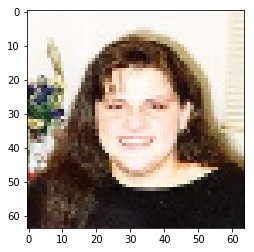

prediction:  [[5.122423e-10 1.000000e+00]]
ground true: [0. 1.]


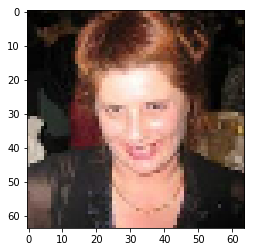

prediction:  [[8.064393e-05 9.999193e-01]]
ground true: [0. 1.]


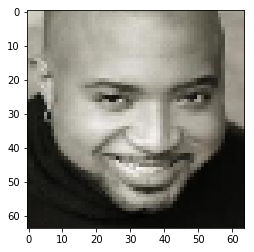

prediction:  [[0.9981034  0.00189656]]
ground true: [0. 1.]


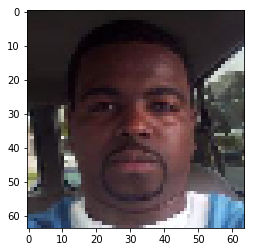

prediction:  [[9.9970835e-01 2.9167498e-04]]
ground true: [1. 0.]


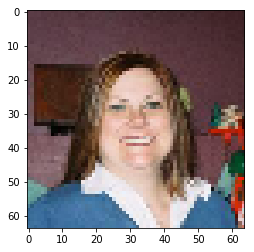

prediction:  [[1.2904157e-04 9.9987090e-01]]
ground true: [0. 1.]


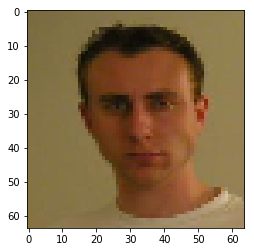

prediction:  [[0.9926414  0.00735862]]
ground true: [1. 0.]


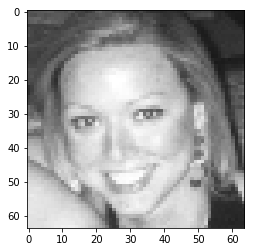

prediction:  [[8.7678738e-05 9.9991226e-01]]
ground true: [0. 1.]


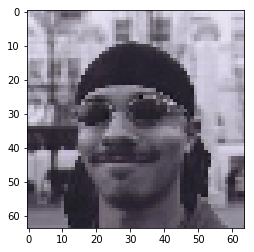

prediction:  [[0.05239137 0.94760865]]
ground true: [0. 1.]


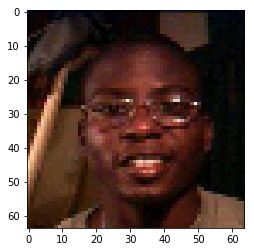

prediction:  [[0.00406106 0.9959389 ]]
ground true: [0. 1.]


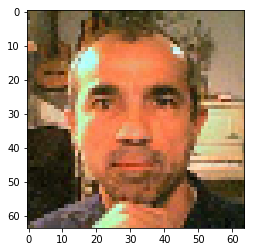

prediction:  [[9.9999952e-01 4.3772644e-07]]
ground true: [1. 0.]


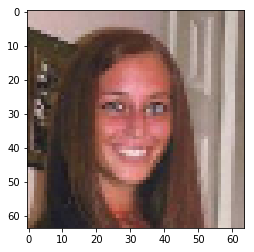

prediction:  [[4.4860267e-18 1.0000000e+00]]
ground true: [0. 1.]


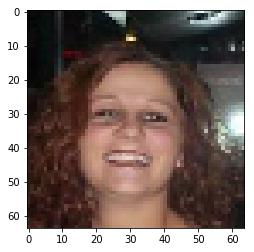

prediction:  [[0.00249117 0.99750876]]
ground true: [0. 1.]


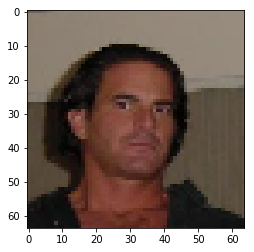

prediction:  [[0.9964747  0.00352533]]
ground true: [1. 0.]


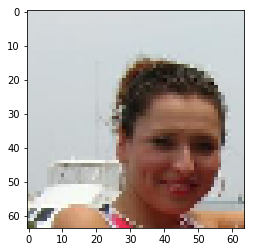

prediction:  [[2.2073448e-06 9.9999774e-01]]
ground true: [0. 1.]


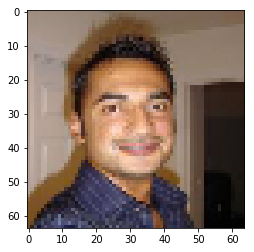

prediction:  [[0.0031048 0.9968952]]
ground true: [0. 1.]


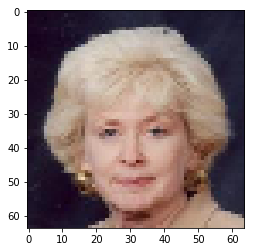

prediction:  [[9.9954385e-01 4.5612018e-04]]
ground true: [1. 0.]


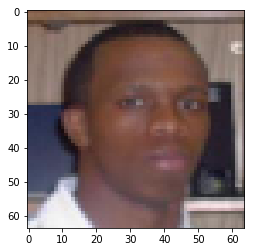

prediction:  [[9.9998796e-01 1.2076952e-05]]
ground true: [1. 0.]


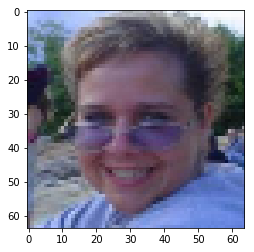

prediction:  [[2.5904334e-09 1.0000000e+00]]
ground true: [0. 1.]


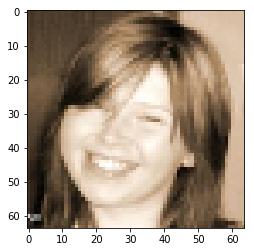

prediction:  [[5.93822e-09 1.00000e+00]]
ground true: [0. 1.]


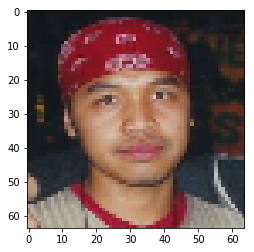

prediction:  [[0.9988335 0.0011665]]
ground true: [1. 0.]


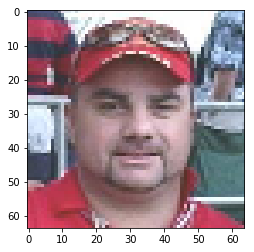

prediction:  [[0.9957016  0.00429832]]
ground true: [1. 0.]


In [20]:

for i, (x, y)in enumerate(zip(x_test, y_test)):
    plt.imshow(x)
    plt.show()
    print('prediction: ', model.predict(x.reshape(1,64,64,3)))
    print('ground true:', y)
    if i == 20:
        break

## Play Video

In [22]:
def logVideoMetadata(video):

    print('current pose: ' + str(video.get(cv2.CAP_PROP_POS_MSEC)))
    print('0-based index: ' + str(video.get(cv2.CAP_PROP_POS_FRAMES)))
    print('pose: ' + str(video.get(cv2.CAP_PROP_POS_AVI_RATIO)))
    print('width: ' + str(video.get(cv2.CAP_PROP_FRAME_WIDTH)))
    print('height: ' + str(video.get(cv2.CAP_PROP_FRAME_HEIGHT)))
    print('fps: ' + str(video.get(cv2.CAP_PROP_FPS)))
    print('codec: ' + str(video.get(cv2.CAP_PROP_FOURCC)))
    print('frame count: ' + str(video.get(cv2.CAP_PROP_FRAME_COUNT)))
    print('format: ' + str(video.get(cv2.CAP_PROP_FORMAT)))
    print('mode: ' + str(video.get(cv2.CAP_PROP_MODE)))
    print('brightness: ' + str(video.get(cv2.CAP_PROP_BRIGHTNESS)))
    print('contrast: ' + str(video.get(cv2.CAP_PROP_CONTRAST)))
    print('saturation: ' + str(video.get(cv2.CAP_PROP_SATURATION)))
    print('hue: ' + str(video.get(cv2.CAP_PROP_HUE)))
    print('gain: ' + str(video.get(cv2.CAP_PROP_GAIN)))
    print('exposure: ' + str(video.get(cv2.CAP_PROP_EXPOSURE)))
    print('convert_rgb: ' + str(video.get(cv2.CAP_PROP_CONVERT_RGB)))
    print('rect: ' + str(video.get(cv2.CAP_PROP_RECTIFICATION)))
    print('iso speed: ' + str(video.get(cv2.CAP_PROP_ISO_SPEED)))
    print('buffersize: ' + str(video.get(cv2.CAP_PROP_BUFFERSIZE)))

In [23]:
def hot_ent_to_text(prediction):
    print(prediction)
    if(prediction[0,0] > prediction[0,1]):
        return 'NON-SMILE'
    else:
        return 'SMILE'

In [33]:
video = cv2.VideoCapture()
video_path = './smile_movie.MOV'
video.open(video_path)
if not video.isOpened():
    print('Error: unable to open video: ' + video_path)

logVideoMetadata(video)

current pose: 0.0
0-based index: 0.0
pose: 0.0016666666666666668
width: 1920.0
height: 1080.0
fps: 29.967845659163988
codec: 828601960.0
frame count: 466.0
format: 0.0
mode: 0.0
brightness: 0.0
contrast: 0.0
saturation: 0.0
hue: 0.0
gain: 0.0
exposure: 0.0
convert_rgb: 0.0
rect: 0.0
iso speed: 0.0
buffersize: 0.0


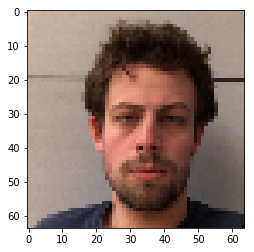

[[0. 1.]]
SMILE
******************************


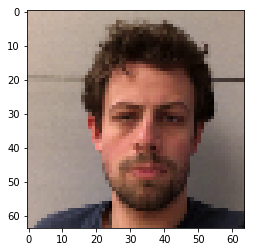

[[0. 1.]]
SMILE
******************************


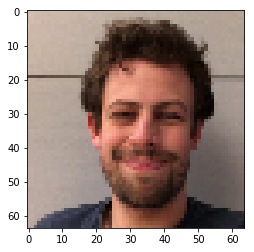

[[0. 1.]]
SMILE
******************************


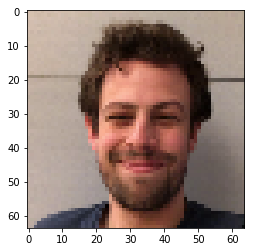

[[0. 1.]]
SMILE
******************************


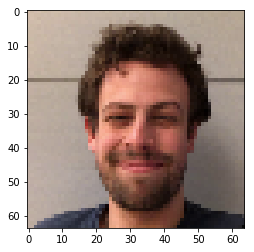

[[0. 1.]]
SMILE
******************************


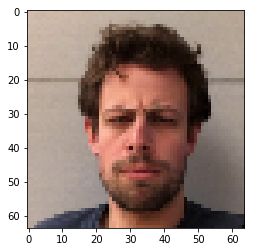

[[0. 1.]]
SMILE
******************************


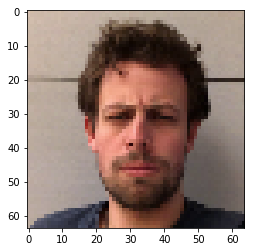

[[2.5627776e-11 1.0000000e+00]]
SMILE
******************************


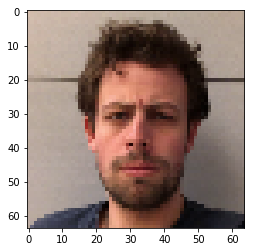

[[0.9949543  0.00504568]]
NON-SMILE
******************************


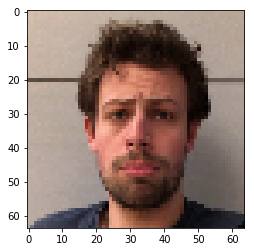

[[9.999999e-01 6.120298e-08]]
NON-SMILE
******************************


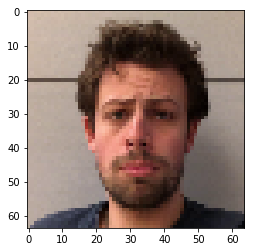

[[1.0000000e+00 2.5093471e-12]]
NON-SMILE
******************************


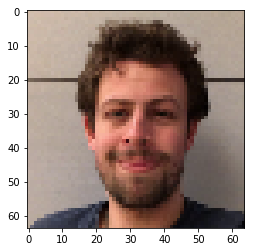

[[0. 1.]]
SMILE
******************************


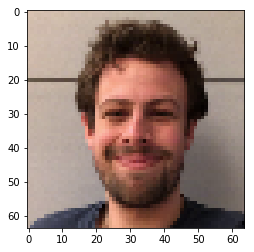

[[0. 1.]]
SMILE
******************************


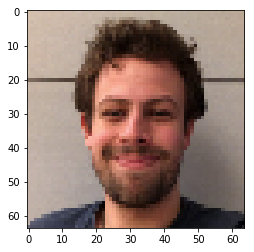

[[0. 1.]]
SMILE
******************************


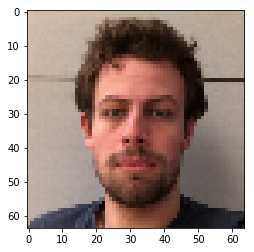

[[1. 0.]]
NON-SMILE
******************************


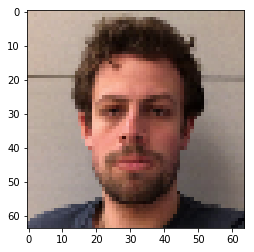

[[1. 0.]]
NON-SMILE
******************************


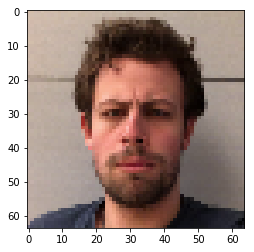

[[1. 0.]]
NON-SMILE
******************************


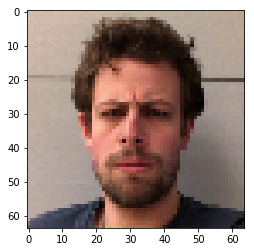

[[1. 0.]]
NON-SMILE
******************************


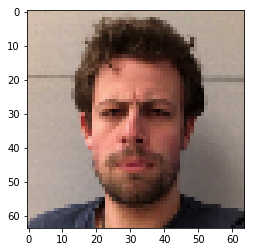

[[1. 0.]]
NON-SMILE
******************************


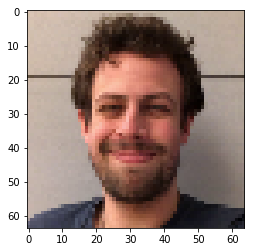

[[0. 1.]]
SMILE
******************************


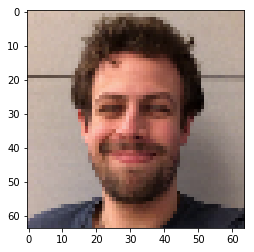

[[0. 1.]]
SMILE
******************************


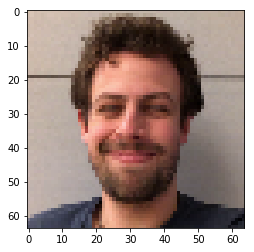

[[0. 1.]]
SMILE
******************************


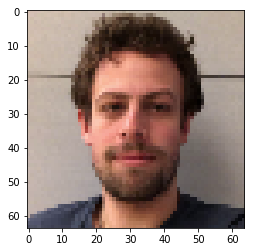

[[1.0000000e+00 2.4896754e-13]]
NON-SMILE
******************************


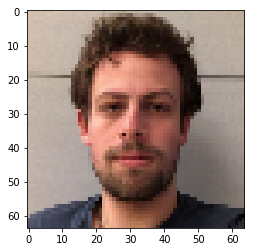

[[1. 0.]]
NON-SMILE
******************************


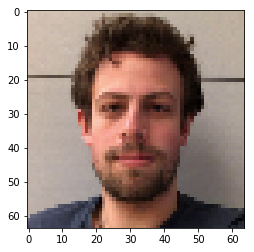

[[1.000000e+00 8.195238e-16]]
NON-SMILE
******************************


In [34]:
resize_ratio = 0.125
roi = [150,550,800,800]
blur_kernel_size = 5

total_frames = int(video.get(cv2.CAP_PROP_FRAME_COUNT) )
for i in range(total_frames):
    
    ret, orig_img = video.read()
    
    if i%20 != 0:
        continue
    
    img = orig_img[roi[0]:roi[0]+roi[2],roi[1]:roi[1]+roi[3]]
    img = cv2.blur(img, (blur_kernel_size,blur_kernel_size))
    img = cv2.resize(img, (64, 64), interpolation=cv2.INTER_CUBIC)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.flip( img, 0 )
    
    plt.imshow(img)
    plt.show()
    
    prediction = model.predict(img.reshape(1,64,64,3))
    print(hot_ent_to_text(prediction))
    print(30*'*')